# Refugios 
Notebook para armar redes bipartidas. Tambien se arman mapas para observar los refugios, graficos de noches acumuladas en refugios y calculo de la distribucion espacial de los refugios junto con su centro de masa .

In [1]:
import redes_bipartitas_de_refugios as rb
import numpy as np
from networkx.algorithms import bipartite
import networkx as nx   
import scipy as sp
import matplotlib.pyplot as plt
import folium
import os
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from datetime import datetime
import grafoDeCsvEncuentros

In [2]:
folder= "D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\todaslascampanas"
dfs,dates,t_names=rb.get_files_and_dates(folder)
file_for_sex_dict= "D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\encuentros_csv\\encuentroscompleto_only_space.csv"
df_refugios=rb.save_refugies_data(dfs,dates,t_names,cutoff_time=1900,distance_refugies=20,file_for_sex=file_for_sex_dict)

In [ ]:
#path_to_Igoto="DataAnalysis\\DatosIgoto2022Todos"
folder_to_Igoto="D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\DatosIgoto2022Todos"
dfsI,datesI,t_namesI=rb.get_files_and_dates_IGOTO(folder_to_Igoto)
file_to_sex= "D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\encuentros_csv\\encuentroscompleto_only_space.csv"
df_refugiosI=rb.save_refugies_data(dfsI,datesI,t_namesI,cutoff_time=2000,distance_refugies=20,data_is_Igoto=True,file_for_sex=file_to_sex)

In [3]:
file_encuentros="D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\encuentros_csv\\encuentros20mincampanas.csv"
file_for_sex_encuentros="D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\encuentros_csv\\encuentroscompleto_only_space.csv"

### Redes bipartidas para datos de todas las campañas 

In [3]:
map=rb.make_map_from_refuguies(df_refugios,topo_map=False)# topologic map 
#SAVE MAP AS HTml
map.save("D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\primerasRedes\\mapa_refugios.html")

In [ ]:
map.save("D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\primerasRedes\\RedBipartitaDeRefugios\\mapa_interactivo_refugios_topo.html")

In [3]:
%matplotlib qt
B=rb.get_bigraph(df_refugios,plot=True,k=0.15)

### Redes bipartidas para datos del IGOTO 

In [ ]:
mapI= rb.make_map_from_refuguies(df_refugiosI)
mapI

In [6]:
%matplotlib qt
B_I=rb.get_bigraph(df_refugiosI,plot=True,k=0.35)

### Dias pasados en el refugio para distintas tortugas 


Aca quiero dibujar como es la acumulada de noches pasadas en el refugio para cada uno de los refuguios mas visitrados.  

In [5]:
refugies=np.unique(df_refugiosI[["lat","lon"]].values.astype("<U22"),axis=0)

# get list of 10 max weight edges in  B with array of refuguies and t_names
max_edges=[]
for i in range(10):
    max_weight=0
    for u,v in B.edges():
        if B[u][v]["weight"]>max_weight:
            max_weight=B[u][v]["weight"]
            u_max=u
            v_max=v
    max_edges.append([u_max,v_max,max_weight])
    B.remove_edge(u_max,v_max)
print(max_edges)


[['T30', 18, 45], ['T54', 37, 28], ['T12', 93, 26], ['T6', 50, 24], ['T79', 3, 24], ['T54', 38, 20], ['T79', 6, 11], ['T79', 10, 11], ['T10', 26, 8], ['T10', 35, 8]]


In [10]:
# draw times spend in refugie in function of day 

fig,axes = plt.subplots(2,3,figsize=(15,10))
#axes[1][2].set_visible(False)


for h in range(6):
    if h==5:
        i=4
    elif h==4:
        i=5
    else:
        i=h
    edge_place=i
    Tort= max_edges[edge_place][0]
    ref= refugies[max_edges[edge_place][1]]
    v_max = max_edges[edge_place][1]

    df_refI_tort = df_refugiosI[df_refugiosI["t_name"]==Tort]
    time_in_ref = np.zeros(len(df_refI_tort))
    dates= []
    for j in range(len(df_refI_tort)):
        df_aux= df_refI_tort.iloc[j]
        date_str= df_aux["date"].split("/")[1][1:]+"/"+ df_aux["date"].split("/")[2]
        dates.append(date_str)
        # check if ref lat and lon are equal to df_aux["lat"] and df_aux["lon"]
        if df_aux["lat"]==ref[0] and df_aux["lon"]==ref[1]:
            if j==0:
                time_in_ref[j]=1
            else:
                time_in_ref[j]= time_in_ref[j-1]+1
        else : 
            if j==0:
                time_in_ref[j]=0
            else:
                time_in_ref[j]= time_in_ref[j-1]
    ax= plt.subplot(2,3,h+1)
    ax.plot(dates,time_in_ref)
    #show only small ticks for the rest of the x_ticks
    # set major ticks in 45 degree location
   
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.tick_params(axis="x",labelrotation=45)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylabel("Nights on refugie")
    #show ytiks as integers
    ax.yaxis.set_major_locator(MultipleLocator(5))
    ax.set_title("Turtle "+Tort+" in refugie " + str(v_max))
    # set grid on minor ticks
    ax.grid(which='both', alpha=0.2)
# change position of subplo
fig.tight_layout()
plt.show()

### Metrica de distribución espacial de los refugios 



Idea: 
Se encuentra el centro de masa de los refugios, como un promedio ponderado en cantidad de noches en el refugio y se calculan las distancias de cada refugio al centro de masa pesadas por la cantidad de noches en el refugio.

$X_{centro}= \sum^{N -1}_{n=0} \frac{i_{n} X_n}{I_{totales}} $

Donde $I_{totales}$ es la cantidad de noches donde se registro que la tortuga durmio en un refugio (depende de cada tortuga), $X_n$ es la coordenada X del refugio n, $i_{n}$ es la cantidad de noches que la tortuga durmio en el refugio n y N la cantidad de refugios totales.  Este proceso se calcula para todas las tortugas. 
Partiendo de $X_{centro}$, la distribucion espacial de los refugios se calcula como:


$D = \sum^{N -1}_{n=0} \frac{|X_n i_n - X_{centro}|}{I_{totales}}$

In [ ]:
df_refugios_complete= pd.concat([df_refugios,df_refugiosI])
df_space_dist = rb.get_mass_center_and_spatialD(df_refugios_complete)


In [ ]:
# get mean value for "machos" and "hembras" of the spatial distance
df_space_dist_heambras= df_space_dist[df_space_dist["sex"]=="hembra"]
df_space_dist_machos= df_space_dist[df_space_dist["sex"]=="macho"]
print("mean spatial distance for hembras refugies: ",round(df_space_dist_heambras["spatialD"].mean()),"m , with std: ",round(df_space_dist_heambras["spatialD"].std()),"m")



print("mean spatial distance for machos refugies: ",round(df_space_dist_machos["spatialD"].mean()),"m , with std: ",round(df_space_dist_machos["spatialD"].std()),"m")

mean spatial distance for hembras refugies:  122 m , with std:  82 m
mean spatial distance for machos refugies:  128 m , with std:  66 m


### Proyeccion de red bipartida

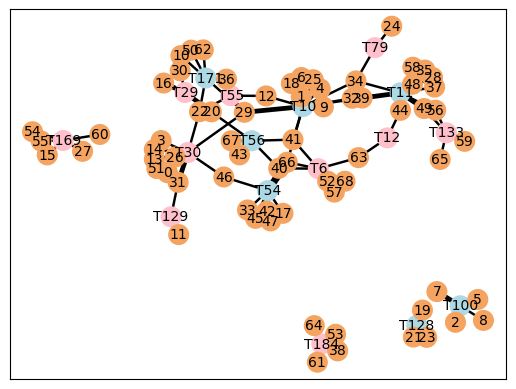

In [4]:
B=rb.get_bigraph(df_refugios,plot=True,k=0.15)

In [5]:
G_from_ref= bipartite.projected_graph(B,df_refugios["t_name"].unique())


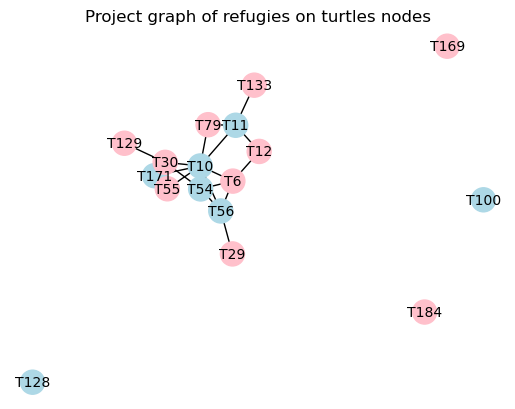

In [6]:
# plot G using networkx
# dont plot nodes that are not connected
remove_nodes= False
# get list of nodes that are connected
nodes_connected=[]
for u,v in G_from_ref.edges():
    nodes_connected.append(u)
    nodes_connected.append(v)
nodes_connected_refus=np.unique(nodes_connected)
# get list of nodes that are not connected
nodes_not_connected=[]
for node in G_from_ref.nodes():
    if node not in nodes_connected:
        nodes_not_connected.append(node)
# remove from G nodes that are not connected
if remove_nodes:
    G_from_ref.remove_nodes_from(nodes_not_connected)
t_nodes_from_ref= G_from_ref.nodes()
color_t= rb.get_colors_turtles(df_refugios,t_nodes_from_ref)
#plot G
plt.figure()
plt.title("Project graph of refugies on turtles nodes")
nx.draw(G_from_ref,with_labels=True,node_color=color_t,font_size=10)
plt.show()

### Comparacion red de encuentros con red de refugios

Comparacion con red de encuentros 20min y 20m. $\\$
En esta comparacion voy a tomar a la proyeccion de la red de refugios como predictor de la red de encuentros, de esta forma puedo usar metricas como recall, accuaracy y precision para compararlas tomando los edge de la red de encuentros como verdaderos y los edge de la red de refugios como predichos.

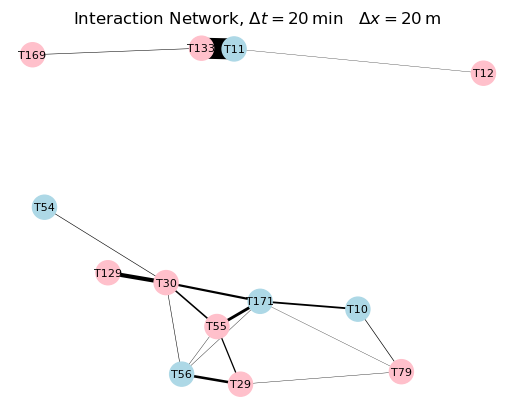

In [7]:
file_encuentros="D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\encuentros_csv\\encuentros20mincampanas.csv"
file_for_sex_encuentros="D:\\facultad\\IB5toCuatri\\Tesis\\MaestriaMarco\\DataAnalysis\\encuentros_csv\\encuentroscompleto_only_space.csv"
title=r"Interaction Network, $\Delta t = 20\,$min   $\Delta x= 20\,$m "
G_encuentros=grafoDeCsvEncuentros.plot_weighted_graph(file_encuentros,title,save=False,save_name="name_fig",get_sex_from_file=True,file_for_sex=file_for_sex_encuentros)

In [15]:
# check if nodes are the same
t_nodes_from_encuentros= G_encuentros.nodes()
print("len nodes_connected_refus: ",len(nodes_connected_refus))
print("len t_nodes_from_encuentros: ",len(t_nodes_from_encuentros))
#check wich nodes are different comparing two lists
t_nodes_from_encuentros= list(t_nodes_from_encuentros)
nodes_connected_refus= list(nodes_connected_refus) 
for i in range(len(t_nodes_from_encuentros)):
    if t_nodes_from_encuentros[i] not in nodes_connected_refus:
        print("node not in refus: ",t_nodes_from_encuentros[i])
for i in range(len(nodes_connected_refus)):
    if nodes_connected_refus[i] not in t_nodes_from_encuentros:
        print("node not in encuentros: ",nodes_connected_refus[i])

len nodes_connected_refus:  13
len t_nodes_from_encuentros:  13
node not in refus:  T169
node not in encuentros:  T6


In [8]:
TP,FP,FN,TN = rb.comparing_two_networks(G_predictor=G_from_ref,G_messaured=G_encuentros)

In [9]:
print("Presision :",TP/(TP+FP))
print("Recall :",TP/(TP+FN))
print("Accuary :", (TP+TN)/(TP+TN+FP+FN))

Presision : 0.42857142857142855
Recall : 0.5294117647058824
Accuary : 0.5121951219512195


### Separacion de dias entre encuentros y noche donde usaron refugio

Otra cosa que me gustaria ver es si los refugios compartidos pasan en dias consecutivos o en el mismo dia. Si los dias estan muy separados me parece que es interesante el resultado. $\\$

Plan para encaralo:
1. Buscar en dfrefugios para refugios compartidos, los dias en que cada tortuga estuvo en ese refugio. 
2. Encontrar la minima separacion en tiempo entre los dias de cada tortuga en el refugio.
3. Despues estaria bueno ver el día mas cercano donde se registro un encuentro. 


In [7]:
df_min_dist_enc_ref = rb.nearest_days_in_ref_to_encounters(file_encuentros=file_encuentros,df_refugios=df_refugios)

In [17]:
# check how many min_dist_encounter are less than 3

encounters_less_than3_days = df_min_dist_enc_ref[df_min_dist_enc_ref["min_dist_encounter"]<1]
print("Encuentros separados en menos de 1 dia de noches en refu:",round(len(encounters_less_than3_days)/len(df_min_dist_enc_ref)*100),"%")

Encuentros separados en menos de 1 dia de noches en refu: 16 %
